## Utils

In [1]:
import time
import random
from pulse2percept.stimuli import Stimulus, BiphasicPulseTrain

def rand_stim(implant, n_electrodes=1):
    maxamp = 15
    maxfreq = 200
    elecs = set()
    while len(elecs) < n_electrodes:
        # add another electrode
        elecs.add(random.choice(list(implant.electrode_names)))
    stim = {}
    for elec in elecs:
        amp = random.random() * maxamp
        freq = random.random() * maxfreq
        pdur = random.expovariate(1)
        while pdur > 1000 / freq / 2 or pdur < 0.01 or pdur > 100:
            pdur = random.expovariate(1)
        stim[elec] = BiphasicPulseTrain(freq, amp, pdur, stim_dur=1000)
    stimulus = Stimulus(stim)
    return stimulus


In [12]:
def time_constant(model, implant, n_elecs=1, n_samples=10, stim_func=rand_stim, verbose=True):
    total_time = 0
    for i in range(n_samples):
        try:
            stim = stim_func(implant, n_electrodes=n_elecs)
            implant.stim = stim
            start = time.time()
            percept = model.predict_percept(implant)
            end = time.time()
            total_time += end - start
        except Exception as e:
            print(e)
            continue
    if verbose:
        print("Average prediction time (%d electrodes): %.0fms" % (n_elecs, total_time / n_samples * 1000))
        print("Average prediction time per electrode: %.0fms" % (total_time / n_samples * 1000 / n_elecs))
    return total_time / n_samples * 1000

In [3]:
def time_random(model, implant, max_elecs=30, n_samples=20, stim_func=rand_stim, plot=False):
    times = []
    elec_counts = []
    for i in range(n_samples):
        try:
            n_elecs = random.randint(1, max_elecs)
            stim = stim_func(implant, n_electrodes=n_elecs)
            implant.stim = stim
            start = time.time()
            percept = model.predict_percept(implant)
            end = time.time()
            times.append(end - start)
            elec_counts.append(n_elecs)
        except ValueError as e:
            print(e)
            continue
    print("Average prediction time (%d electrodes): %.0fms" % (n_elecs, sum(times) / n_samples * 1000))
    print("Average prediction time per electrode: %.0fms" % (sum(times) / sum(elec_counts) * 1000))
    
    if plot:
        plt.scatter(elec_counts, times, t)
        plt.title("Prediction Time vs Electrode Count")
    
    return sum(times) / n_samples * 1000
    

## Testing

In [4]:
from pulse2percept.models import AxonMapModel
from pulse2percept.implants import ArgusII, DiskElectrode, ProsthesisSystem
from pulse2percept.stimuli import BiphasicPulseTrain

import numpy as np
import matplotlib.pyplot as plt

### Original (Serial, variable length axons)

#### Axon Map

In [29]:
model = AxonMapModel(engine='cython')
model.build()
implant = ArgusII(rot=45)

In [30]:
model.axon_contrib.shape

(14641, 30, 3)

In [6]:
time_constant(model, implant, n_elecs=1, n_samples=20)
time_constant(model, implant, n_elecs=15, n_samples=2)

Average prediction time (1 electrodes): 320ms
Average prediction time per electrode: 320ms
Average prediction time (15 electrodes): 16750ms
Average prediction time per electrode: 1117ms


16749.55105781555

Done with 1 elecs
Done with 15 elecs


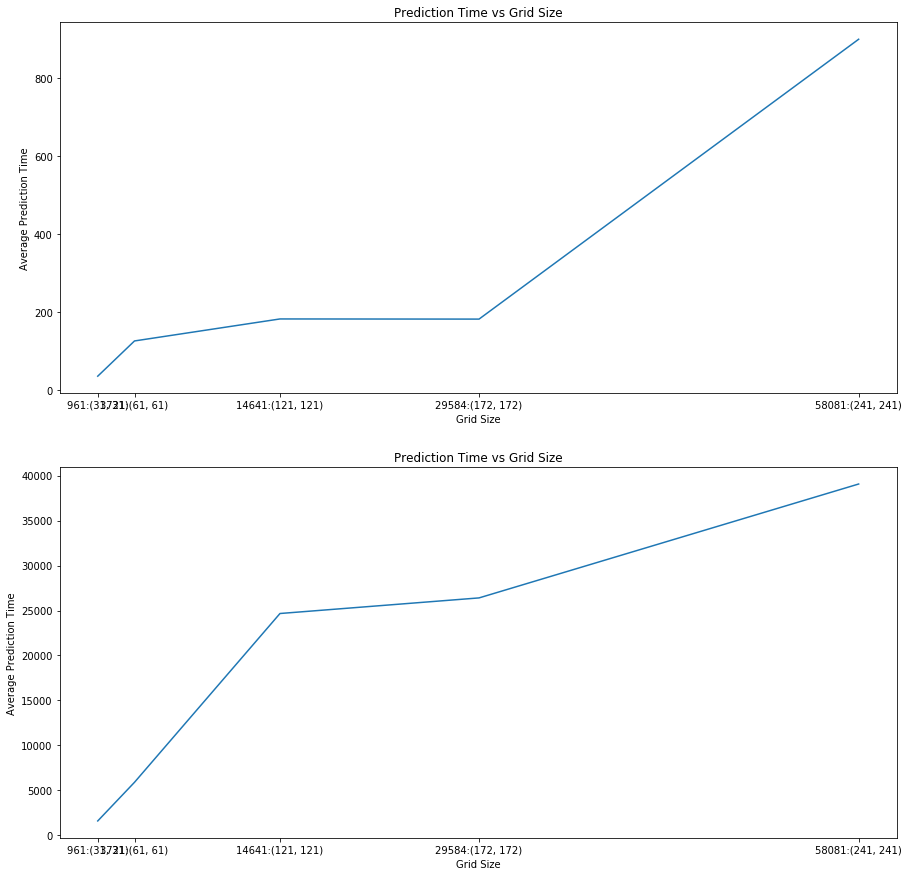

In [39]:
xysteps = [1, 0.5, 0.25, 0.175, 0.125]
fig, axes = plt.subplots(2,1, figsize=(15, 15))
for n_elecs, ax in zip([1, 15], axes):
    
    times = []
    n_points = []
    sizes = []
    for step in xysteps:
        model = AxonMapModel(xystep=step, xrange=(-15, 15), yrange=(-15, 15), engine='cython')
        model.build()
        implant = ArgusII(rot=45)
        times.append(time_constant(model, implant, n_samples=1, n_elecs=n_elecs, verbose=False))
        sizes.append((len(model.grid.xret), len(model.grid.yret)))
        n_points.append(len(model.grid.xret) * len(model.grid.yret))
    print("Done with %d elecs" % (n_elecs))
    ax.plot(n_points, times, label=str(n_elecs))
    ax.set_xticks(n_points)
    ax.set_xticklabels([str(n_points[i]) + ":" + str(sizes[i]) for i in range(len(sizes))])
    ax.set_xlabel("Grid Size")
    ax.set_ylabel("Average Prediction Time")
    ax.set_title("Prediction Time vs Grid Size")
    
fig.show()
    

In [ ]:
n_elecs = np.arange(1, 60, 6)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
times = []
model = AxonMapModel(xystep=step, xrange=(-15, 15), yrange=(-15, 15), engine='cython')
model.build()
implant = ArgusII(rot=45)
for n_elec in n_elecs:
    times.append(time_constant(model, implant, n_samples=1, n_elecs=n_elec, verbose=True))
ax.plot(n_elecs, times)
ax.set_xlabel("Number of Active Electrodes")
ax.set_ylabel("Average Prediction Time")
ax.set_title("Prediction Time vs Number of Electrodes")
    
fig.show()
    

Average prediction time (1 electrodes): 2018ms
Average prediction time per electrode: 2018ms
Average prediction time (7 electrodes): 30627ms
Average prediction time per electrode: 4375ms
Average prediction time (13 electrodes): 60583ms
Average prediction time per electrode: 4660ms
Average prediction time (19 electrodes): 124200ms
Average prediction time per electrode: 6537ms
Average prediction time (25 electrodes): 292719ms
Average prediction time per electrode: 11709ms
Average prediction time (31 electrodes): 297510ms
Average prediction time per electrode: 9597ms
Average prediction time (37 electrodes): 532672ms
Average prediction time per electrode: 14397ms
Average prediction time (43 electrodes): 590812ms
Average prediction time per electrode: 13740ms
Average prediction time (49 electrodes): 898582ms
Average prediction time per electrode: 18338ms


Text(0.5, 0, 'Number of Electrodes')

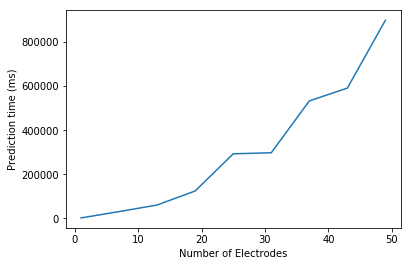

In [1]:
import matplotlib.pyplot as plt
times = [2000, 30627, 60583, 124200, 292719, 297510, 532672, 590812, 898582]
n_elecs = [1, 7, 13, 19, 25, 31, 37, 43, 49]
plt.plot(n_elecs, times)
plt.ylabel("Prediction time (ms)")
plt.xlabel("Number of Electrodes")

#### Biphasic Axon Map

In [5]:
from pulse2percept.models import BiphasicAxonMapModel

In [6]:
model = BiphasicAxonMapModel()
model.build()
implant = ArgusII(rot=45)

In [7]:
time_constant(model, implant, n_elecs=1, n_samples=20)
time_constant(model, implant, n_elecs=15, n_samples=2)
# time_random(model, implant, n_samples=50, plot=True)

Average prediction time (1 electrodes): 10ms
Average prediction time per electrode: 10ms
Average prediction time (15 electrodes): 103ms
Average prediction time per electrode: 7ms


103.29043865203857

Done with 1 elecs
Done with 15 elecs


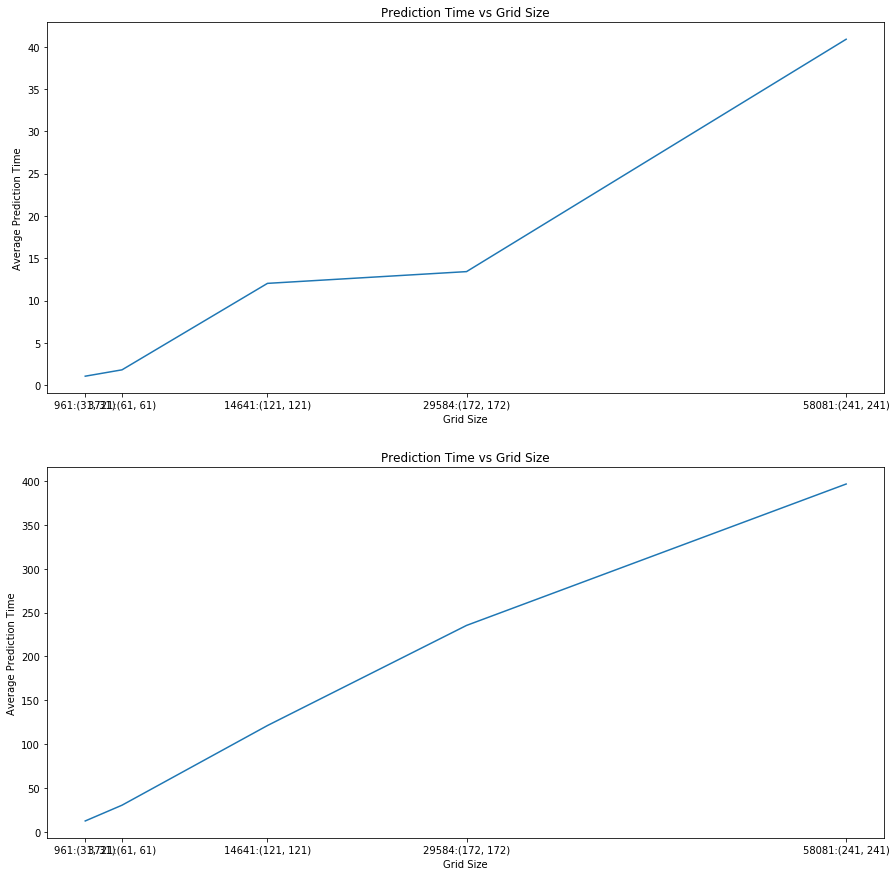

In [8]:
xysteps = [1, 0.5, 0.25, 0.175, 0.125]
fig, axes = plt.subplots(2,1, figsize=(15, 15))
for n_elecs, ax in zip([1, 15], axes):
    
    times = []
    n_points = []
    sizes = []
    for step in xysteps:
        model = BiphasicAxonMapModel(xystep=step, xrange=(-15, 15), yrange=(-15, 15), engine='cython')
        model.build()
        implant = ArgusII(rot=45)
        times.append(time_constant(model, implant, n_samples=1, n_elecs=n_elecs, verbose=False))
        sizes.append((len(model.grid.xret), len(model.grid.yret)))
        n_points.append(len(model.grid.xret) * len(model.grid.yret))
    print("Done with %d elecs" % (n_elecs))
    ax.plot(n_points, times, label=str(n_elecs))
    ax.set_xticks(n_points)
    ax.set_xticklabels([str(n_points[i]) + ":" + str(sizes[i]) for i in range(len(sizes))])
    ax.set_xlabel("Grid Size")
    ax.set_ylabel("Average Prediction Time")
    ax.set_title("Prediction Time vs Grid Size")
    
fig.show()



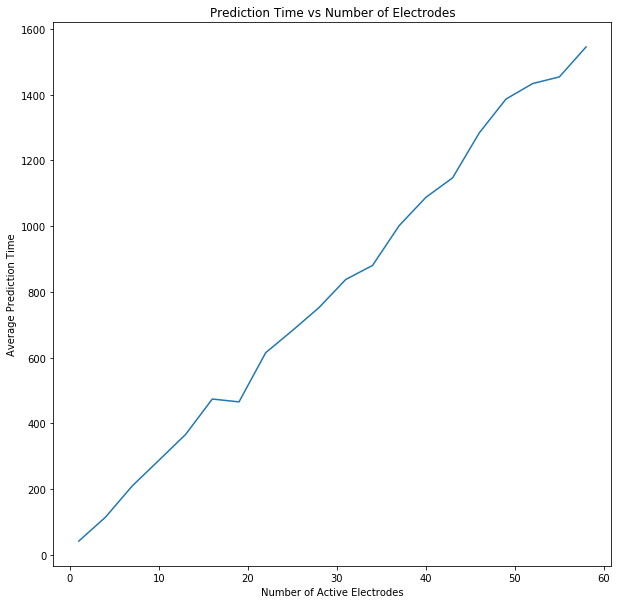

In [13]:
n_elecs = np.arange(1, 60, 3)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
times = []
model = BiphasicAxonMapModel(xystep=step, xrange=(-15, 15), yrange=(-15, 15), engine='cython')
model.build()
implant = ArgusII(rot=45)
for n_elec in n_elecs:
    times.append(time_constant(model, implant, n_samples=5, n_elecs=n_elec, verbose=False))
ax.plot(n_elecs, times)
ax.set_xlabel("Number of Active Electrodes")
ax.set_ylabel("Average Prediction Time")
ax.set_title("Prediction Time vs Number of Electrodes")
    
fig.show()
    

## New (Same length axons, still cython)